Market Risk Analysis: Value at Ris (VaR) Calculation
Author: Choirina Alivia  
Date ; 2025-04-24

Project Overview
This notebook demonstrates:
1. Historical VaR calculation
2. Monte Carlo VaR simulation (GBM model)
3. Stress testing and visualization

In [20]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

1. Data Preparation

In [21]:
data = pd.read_csv('HistoricalData.csv')

In [22]:
prices = data["Close"]

In [23]:
# Convert the 'Close' column to numeric, removing the dollar sign and commas
data["Close"] = pd.to_numeric(data["Close"].str.replace('[\$,]', '', regex=True))

# Now you can extract prices and calculate returns
prices = data["Close"]
returns = prices.pct_change().dropna()

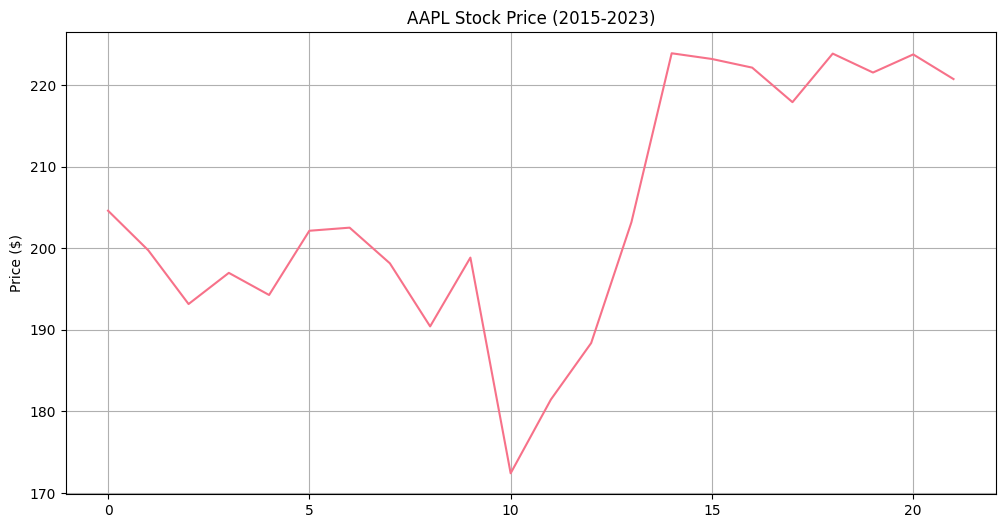

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(prices)
plt.title(f"{ticker} Stock Price (2015-2023)")
plt.ylabel("Price ($)")
plt.grid(True)
plt.show()

2. Exploratory Data Analysis
Basic statistics and return distribution

In [25]:
print("Return Statistics:")
print(f"Mean: {returns.mean():.4f}")
print(f"Std Dev: {returns.std():.4f}")
print(f"Skewness: {returns.skew():.4f}")
print(f"Kurtosis: {returns.kurtosis():.4f}")

Return Statistics:
Mean: 0.0048
Std Dev: 0.0486
Skewness: -0.5925
Kurtosis: 2.4827


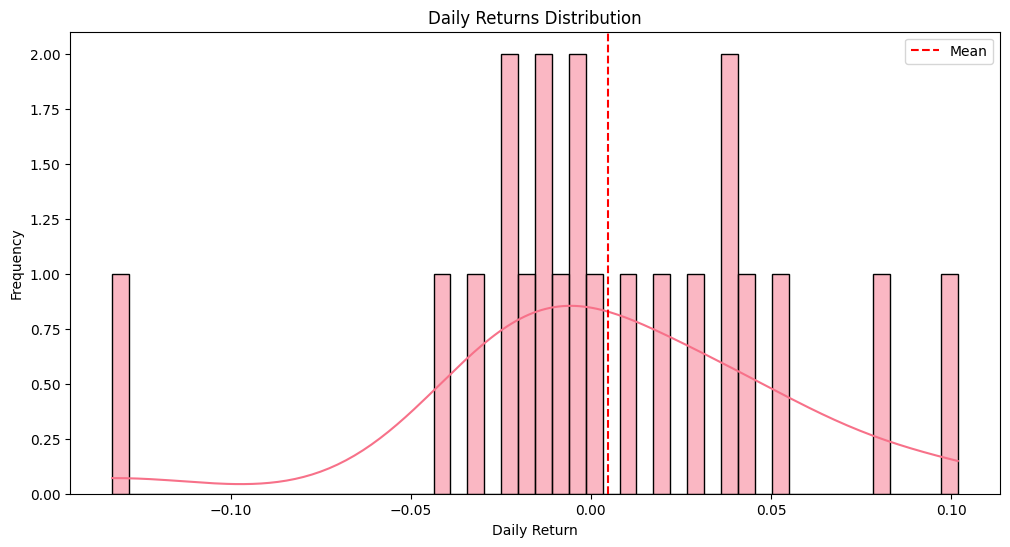

In [26]:
plt.figure(figsize=(12, 6))
sns.histplot(returns, kde=True, bins=50)
plt.title("Daily Returns Distribution")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.axvline(x=returns.mean(), color='r', linestyle='--', label='Mean')
plt.legend()
plt.show()

3. Historical VaR Calculation
Non-parametric method using empirical quantiles

In [27]:
def historical_var(returns, confidence=0.95, display=True):
    """Calculate Historical Value at Risk"""
    var = np.percentile(returns, 100 * (1 - confidence))

    if display:
        print(f"{confidence*100:.0f}% 1-day Historical VaR: {var:.2%}")

        # Plot
        plt.figure(figsize=(12, 6))
        sns.histplot(returns, kde=True, bins=50)
        plt.axvline(var, color='red', linestyle='--',
                   label=f'{confidence*100:.0f}% VaR: {var:.2%}')
        plt.title("Historical VaR Estimation")
        plt.xlabel("Daily Return")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

    return var


95% 1-day Historical VaR: -3.90%


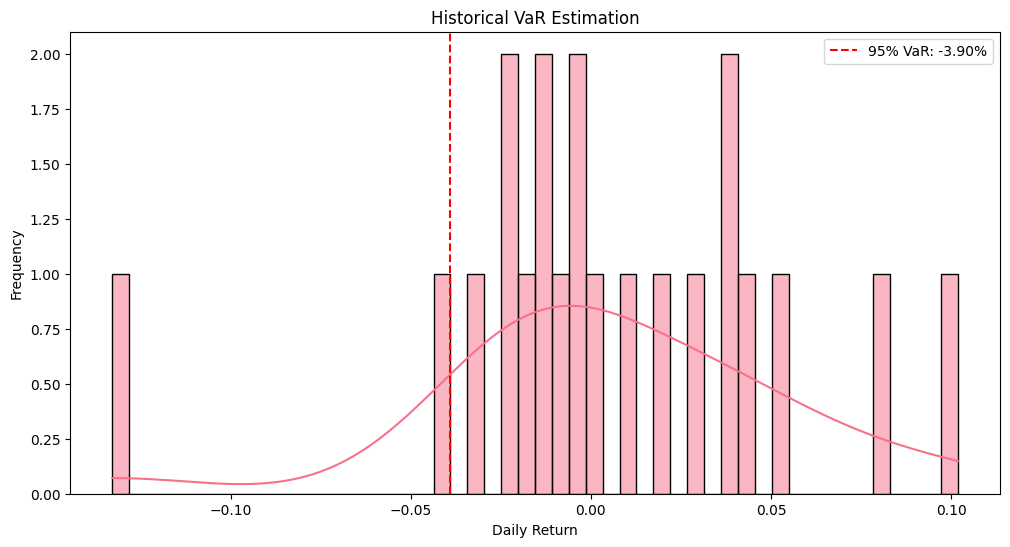

99% 1-day Historical VaR: -11.41%


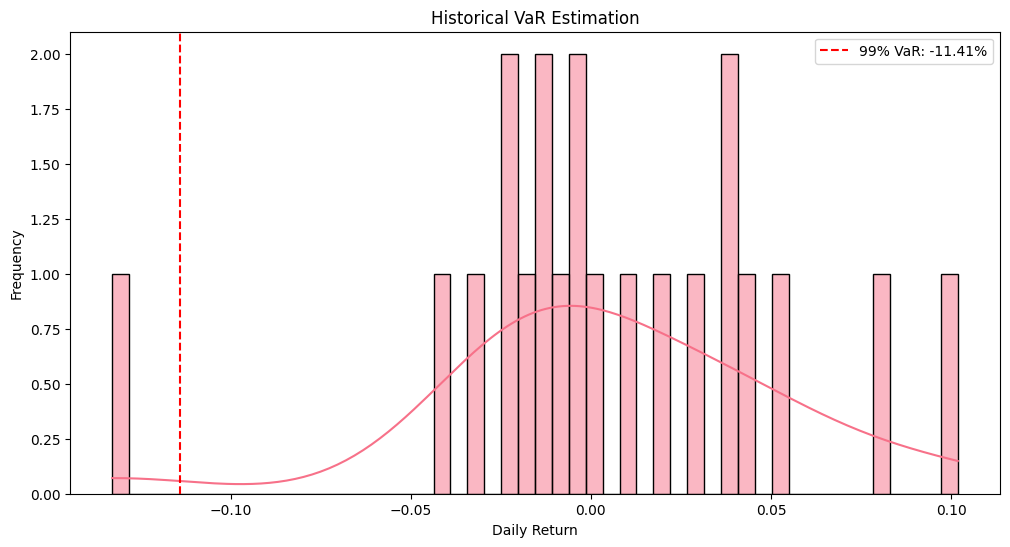

In [28]:
var_95 = historical_var(returns, 0.95)
var_99 = historical_var(returns, 0.99)

4. Monte Carlo VaR Simulation
Parametric method using Geometric Brownian Motion

95% 1-day Monte Carlo VaR: -7.41%


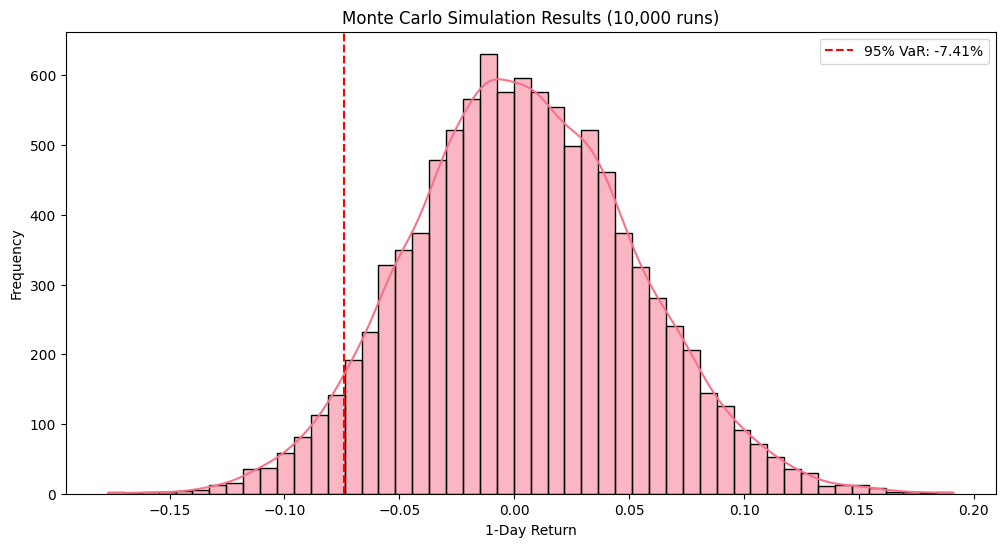

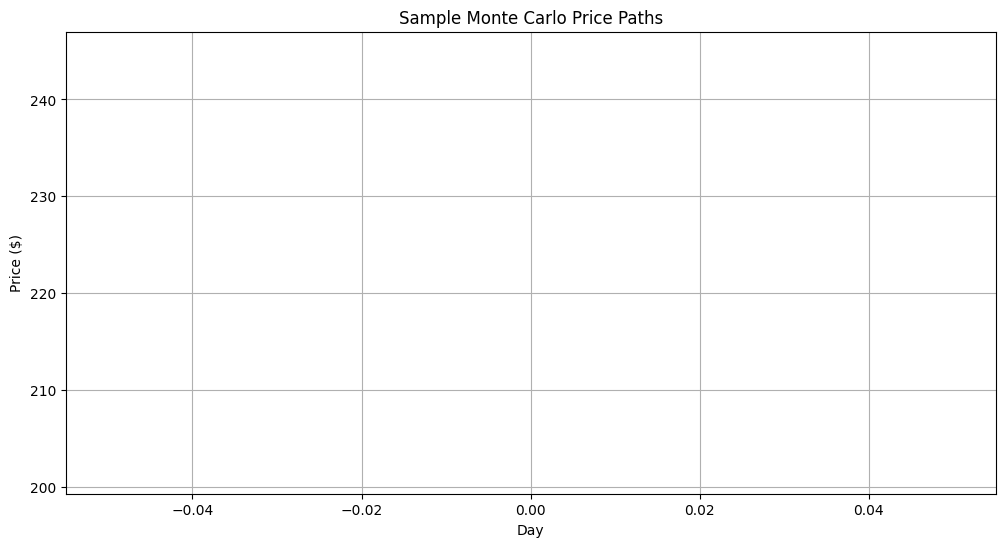

99% 1-day Monte Carlo VaR: -10.22%


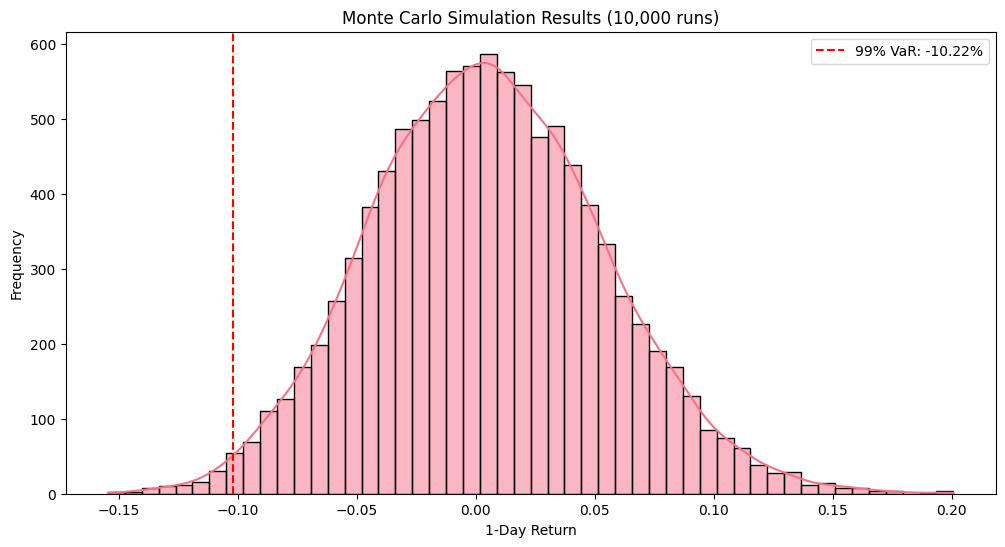

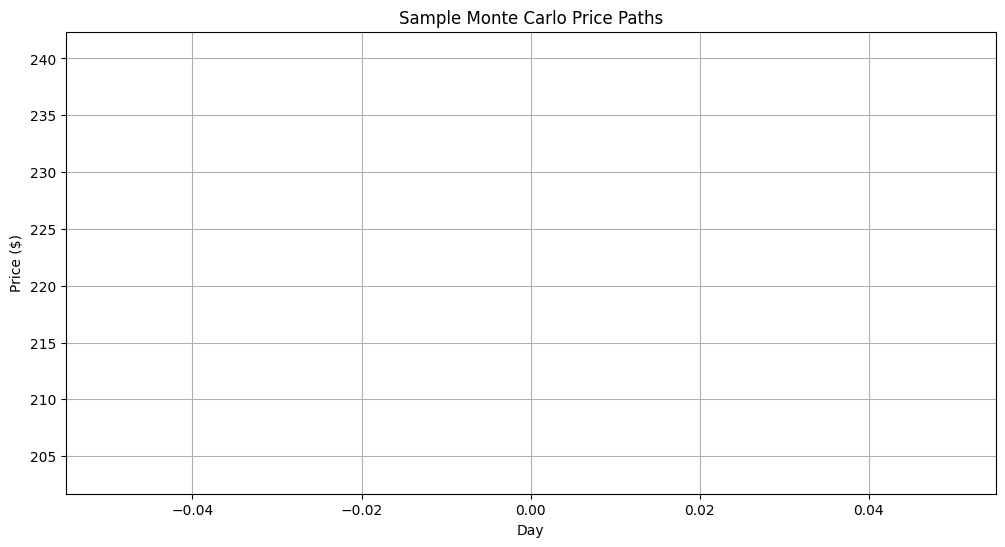

In [30]:
def monte_carlo_var(S0, mu, sigma, days=1, n_sims=10000, confidence=0.95, display=True):
  # Convert annualized to daily parameters
    dt = days/252
    drift = (mu - 0.5 * sigma**2) * dt
    diffusion = sigma * np.sqrt(dt)

    # Simulate returns
    Z = np.random.standard_normal(n_sims)
    simulated_returns = np.exp(drift + diffusion * Z) - 1
    # Calculate VaR
    var = np.percentile(simulated_returns, 100 * (1 - confidence))

    if display:
        print(f"{confidence*100:.0f}% {days}-day Monte Carlo VaR: {var:.2%}")
        # Plot simulation results
        plt.figure(figsize=(12, 6))
        sns.histplot(simulated_returns, bins=50, kde=True)
        plt.axvline(var, color='red', linestyle='--',
                   label=f'{confidence*100:.0f}% VaR: {var:.2%}')
        plt.title(f"Monte Carlo Simulation Results ({n_sims:,} runs)")
        plt.xlabel(f"{days}-Day Return")
        plt.ylabel("Frequency")
        plt.legend()
        plt.show()

        # Plot sample price paths
        plt.figure(figsize=(12, 6))
        for i in range(20):  # Plot first 20 paths
            plt.plot(S0 * (1 + simulated_returns[i]))
        plt.title("Sample Monte Carlo Price Paths")
        plt.ylabel("Price ($)")
        plt.xlabel("Day")
        plt.grid(True)
        plt.show()
    return var

 # Get parameters
S0 = prices.iloc[-1]  # Latest price, using iloc to access the last element by position
mu = returns.mean() * 252  # Annualized return
sigma = returns.std() * np.sqrt(252)  # Annualized volatility

# Calculate MC VaR
mc_var_95 = monte_carlo_var(S0, mu, sigma, days=1, confidence=0.95)
mc_var_99 = monte_carlo_var(S0, mu, sigma, days=1, confidence=0.99)

5. Stress Testing
Analyze VaR under extreme market conditions

In [31]:
stress_sigma = sigma * 1.5
stress_var_95 = monte_carlo_var(S0, mu, stress_sigma, confidence=0.95, display=False)
stress_var_99 = monte_carlo_var(S0, mu, stress_sigma, confidence=0.99, display=False)

print("\nStress Test Results (Volatility +50%):")
print(f"95% 1-day VaR under stress: {stress_var_95:.2%} (vs normal {mc_var_95:.2%})")
print(f"99% 1-day VaR under stress: {stress_var_99:.2%} (vs normal {mc_var_99:.2%})")


Stress Test Results (Volatility +50%):
95% 1-day VaR under stress: -10.91% (vs normal -7.41%)
99% 1-day VaR under stress: -15.07% (vs normal -10.22%)


6. VaR Comparison
Compare Historical vs Monte Carlo methods

In [32]:
results = pd.DataFrame({
    'Method': ['Historical', 'Monte Carlo', 'Stress Test (Vol +50%)'],
    '95% VaR': [var_95, mc_var_95, stress_var_95],
    '99% VaR': [var_99, mc_var_99, stress_var_99]
})

display(results.style.format({
    '95% VaR': '{:.2%}',
    '99% VaR': '{:.2%}'
}).set_caption("VaR Comparison"))

,Method,95% VaR,99% VaR
0,Historical,-3.90%,-11.41%
1,Monte Carlo,-7.41%,-10.22%
2,Stress Test (Vol +50%),-10.91%,-15.07%
